<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Etv2_Project_Candidate_gene_Expression_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title load R
%load_ext rpy2.ipython

In [ ]:
### install R packages ###
%%R
install.packages("devtools")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("SummarizedExperiment", "SingleCellExperiment", "knitr", "LoomExperiment", "batchelor"))
devtools::install_github("immunogenomics/harmony")
devtools::install_github('theislab/kBET')
#devtools::install_version("spatstat", version = "1.64-1", repos = "http://cran.us.r-project.org")
#remotes::install_version("Seurat", version = "3.2.3")
remotes::install_github(repo = 'satijalab/seurat')
devtools::install_github('satijalab/seurat-wrappers')
devtools::install_github("cellgeni/sceasy")
install.packages("rliger")
remotes::install_github("rstudio/reticulate")
install.packages("SparseM")

In [ ]:
%%R
library(Seurat)
library(SingleCellExperiment)
library(tidyverse)
library(magrittr)
library(kable)

In [60]:
%%R
system("wget -x -c -nH https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = readRDS(file = "gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = as(sce, "SingleCellExperiment")
rownames(sce) = rowData(sce)$name
colnames(sce)  = colData(sce)$barcodes
so = as.Seurat(sce, data = NULL)
so

class: SingleCellExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster
reducedDimNames(0):
altExpNames(0):


In [63]:
%%R
so = CreateSeuratObject(counts = GetAssayData(so, slot = "counts"), meta.data = so@meta.data)
so[["percent.mt"]] = PercentageFeatureSet(so, pattern = "^mt-")
so[["percent.rpl"]] = PercentageFeatureSet(so, pattern = "^Rpl")
so[["percent.rps"]] = PercentageFeatureSet(so, pattern = "^Rps")
s.genes <- cc.genes$s.genes %>% str_to_title()
g2m.genes <- cc.genes$g2m.genes %>% str_to_title()
so <- CellCycleScoring(so, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
so

R[write to console]: Warning:
R[write to console]:  The following features are not present in the object: Mlf1ip, not searching for symbol synonyms

R[write to console]: Warning:
R[write to console]:  The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms



An object of class Seurat 
17010 features across 15475 samples within 1 assay 
Active assay: RNA (17010 features, 0 variable features)


In [65]:
%%R
so = NormalizeData(so)
so = FindVariableFeatures(so)
so = ScaleData(so, vars.to.regress = c("nCount_RNA", "nFeature_RNA", "percent.mt", "percent.rpl"))
so = RunPCA(so)
so

R[write to console]: PC_ 1 
Positive:  Pclaf, H2afz, Ybx1, Eif5a, Cycs, Ranbp1, Ran, Lgals1, Cks1b, Birc5 
	   Nhp2, Pfn1, Rps27l, Hspd1, Timm8a1, Selenoh, Tuba1b, Ptma, Lyar, Tagln2 
	   Mif, Rrm2, Tubb6, Nme1, Cfl1, Hmgb2, Mrpl42, Ppa1, Cnbp, S100a6 
Negative:  Ptn, Col3a1, Igfbp4, Mgp, Selenop, Ifitm3, Malat1, Tgfbi, Colec12, Mmp2 
	   Mest, Egr1, Neat1, Atp1b1, Col6a1, Rgs2, Gpm6b, Nr2f1, Plat, Plpp3 
	   Smoc2, Adgrf5, Plscr2, Ebf2, Thbs2, Serpine2, Xylt1, Tigd2, Hprt, Mt1 
PC_ 2 
Positive:  Cyp1b1, Thbs1, Cxcl12, Lox, Gas1, Adamts5, Rspo2, Col1a1, Slc1a3, Pcdh19 
	   Mmp2, Meg3, Fzd1, Svep1, Vgll3, Sfrp1, Spcs3, Fgf7, Mgp, Pdk4 
	   Crim1, Myl9, Cd24a, Slc38a4, Prrx2, Ddah1, Acta2, Fam198b, Npnt, Rflnb 
Negative:  Nptx1, Nrp2, Tinagl1, Gchfr, Lgals3, Dpysl3, Tmem158, Itga6, Ctsl, S100a4 
	   Dkk2, Dtna, Flt1, Crip2, Nrarp, Thy1, Cdkn2a, Gng11, Lingo2, Arpc1b 
	   Areg, Glud1, Cd47, Kctd12, Card19, Aldoa, Cd34, Cdh5, Tbx1, Ctla2a 
PC_ 3 
Positive:  Ahnak, Cd44, Ankrd1, Dkk2, Col1a

In [71]:
%%R
so[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(so@meta.data[,c("umap.V1", "umap.V2")]), key = "umap_", assay = DefaultAssay(so))

In [ ]:
%%R
so = RunUMAP(so, reduction = "pca", dims = 1:20, seed.use = 1)
so <- FindNeighbors(so, reduction = 'umap', dims = 1:2, verbose = FALSE)
so <- FindClusters(so, algorithm = 3, resolution = 0.1, verbose = FALSE)
so$cluster <- Idents(so)
so

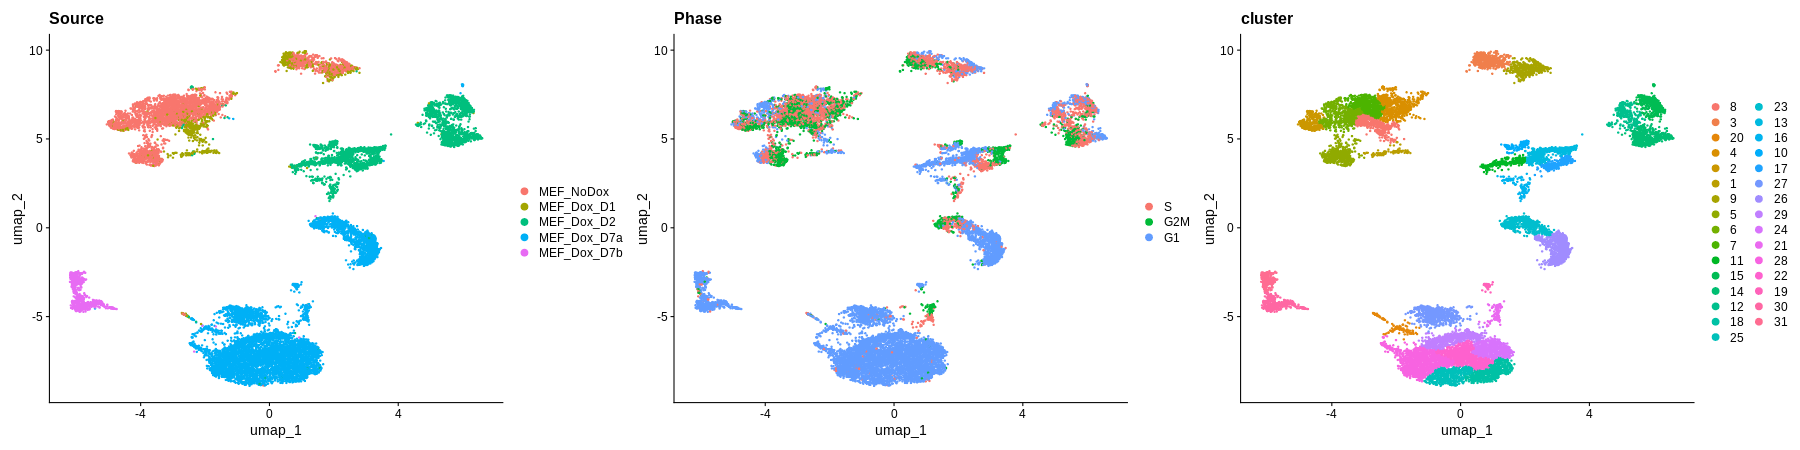

In [74]:
%%R -w 1800 -h 450
Seurat::Idents(so) = "group"
p1 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = TRUE, raster = FALSE) + ggplot2::ggtitle(label = "Source")
Seurat::Idents(so) = "Phase"
p2 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = FALSE, raster = FALSE) + ggplot2::ggtitle(label = "Phase")
Seurat::Idents(so) = "cluster"
p3 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = FALSE, raster = FALSE) + ggplot2::ggtitle(label = "cluster")
p1 + p2 + p3

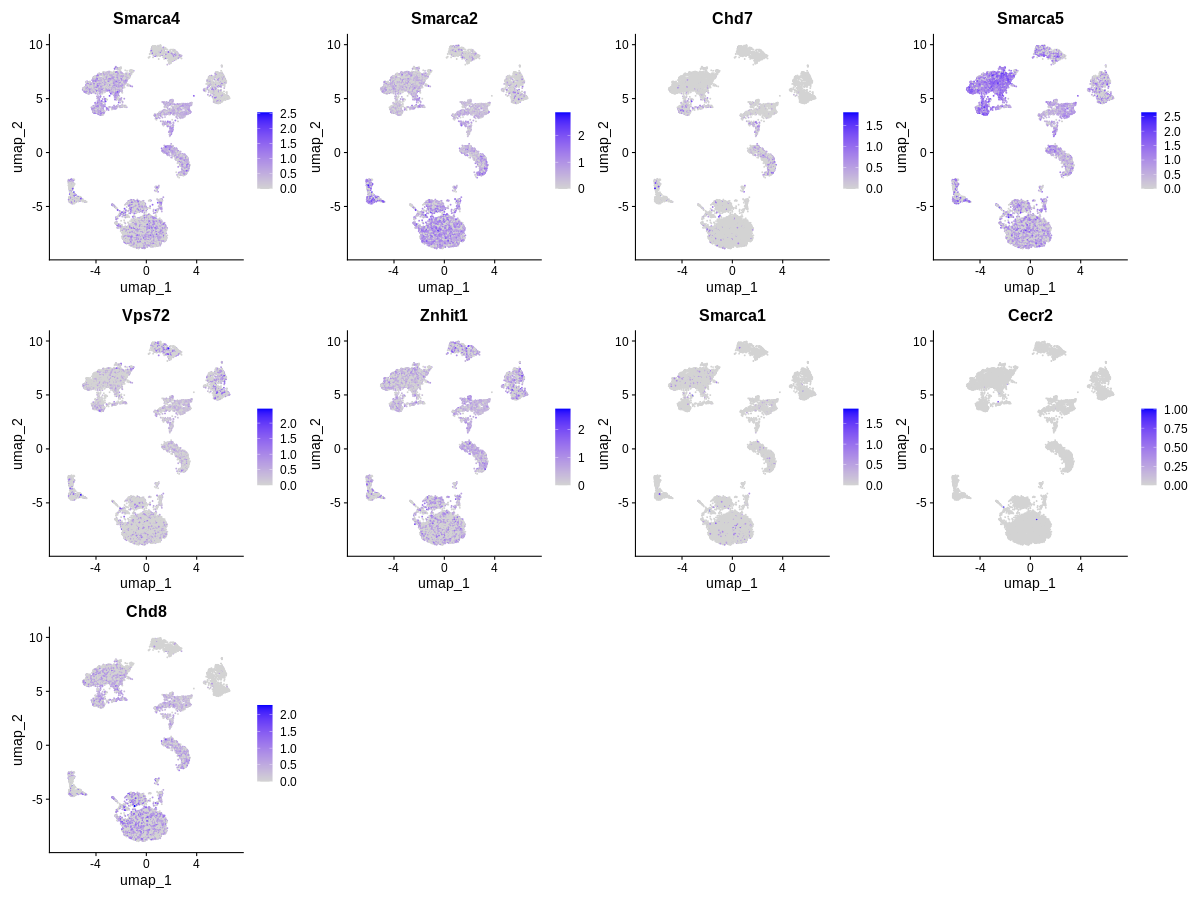

In [79]:
%%R -w 1200 -h 900
Genes = c("Smarca4","Smarca2", "Chd7", "Smarca5", "Vps72", "Znhit1", "Smarca1", "Cecr2", "Chd8")
FeaturePlot(so, dims = c(1, 2), features = Genes, pt.size = 0.25, cols = c('lightgrey', "blue"), ncol = 4, raster = FALSE)

In [80]:
%%R
Idents(so) = "group"
mdd1_markers = FindMarkers(so, ident.1 = "MEF_Dox_D1", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd2_markers = FindMarkers(so, ident.1 = "MEF_Dox_D2", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd7a_markers = FindMarkers(so, ident.1 = "MEF_Dox_D7a", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd7b_markers = FindMarkers(so, ident.1 = "MEF_Dox_D7b", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
all_markers = FindMarkers(so, ident.1 = c("MEF_Dox_D1", "MEF_Dox_D2", "MEF_Dox_D7a", "MEF_Dox_D7b"), ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)

R[write to console]: For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 10s
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 38s
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06m 23s
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03m 04s


In [98]:
%%R
test = c("MEF_Dox_D1", "MEF_Dox_D2", "MEF_Dox_D7a", "MEF_Dox_D7b", "all")
markers = list(mdd1_markers, mdd2_markers, mdd7a_markers, mdd7b_markers, all_markers)
for(i in 1:length(test)){
  temp = markers[[i]][c("Smarca4","Smarca2", "Chd7", "Smarca5", "Vps72", "Znhit1", "Smarca1", "Cecr2", "Chd8"),]
  temp = temp[complete.cases(temp),]
  write.csv(temp, file = sprintf("%s_vs_NoDox.csv", test[[i]]))
  print(sprintf("Results for testing %s vs No Dox condition", test[[i]]))
  print(temp) 
}


[1] "Results for testing MEF_Dox_D1 vs No Dox condition"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
Smarca4 3.518446e-04  0.1156439 0.546 0.487 1.000000e+00
Smarca2 1.424598e-04  0.1138542 0.481 0.415 1.000000e+00
Vps72   3.369075e-09  0.1123720 0.352 0.245 5.730797e-05
[1] "Results for testing MEF_Dox_D2 vs No Dox condition"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
Vps72  1.605011e-52  0.1213804 0.469 0.245 2.730124e-48
Znhit1 1.081992e-30  0.1694149 0.666 0.478 1.840468e-26
[1] "Results for testing MEF_Dox_D7a vs No Dox condition"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
Smarca2 4.452240e-299  0.6674326 0.701 0.415 7.573260e-295
Chd8     1.696668e-62  0.2741792 0.474 0.351  2.886033e-58
[1] "Results for testing MEF_Dox_D7b vs No Dox condition"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
Smarca2 5.992311e-83  1.1744972 0.593 0.415 1.019292e-78
Vps72   1.431081e-04  0.1572524 0.155 0.245 1.000000e+00
Znhit1  4.065303e-08  0.13